In [4]:
import os
import pandas as pd 
import numpy as np
import torch
import pytorch_lightning as L
import torch.utils.data as data
from data.preprocess import ConcatDataset
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns
from models.adversarial_XVAE_multiCov_multipleAdvNet import XVAE_w_advNet_pingpong

# Evaluate deconfounding performance

## Load dataset

In [5]:

''' Set seeds for replicability  -Ensure that all operations are deterministic on GPU (if used) for reproducibility '''
np.random.seed(1234)
torch.manual_seed(1234)
L.seed_everything(1234)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

''' Set PATHs '''
PATH_data = "Data"

''' Load data '''
X1 = np.loadtxt(os.path.join(PATH_data, "TCGA",'TCGA_mRNAs_processed.csv'), delimiter=",")
X2 = np.loadtxt(os.path.join(PATH_data, "TCGA",'TCGA_miRNAs_processed.csv'), delimiter=",")
X1 = torch.from_numpy(X1).to(torch.float32)
X2 = torch.from_numpy(X2).to(torch.float32)
traits = np.loadtxt(os.path.join(PATH_data, "TCGA",'TCGA_clinic.csv'), delimiter=",", skiprows=1, usecols=(1,2,3,4,5))
# Get traits
Y = traits[:, -1]

''' Split into training and validation sets '''
n_samples = X1.shape[0]
indices = np.random.permutation(n_samples)
train_idx, val_idx, test_idx = indices[:2100], indices[2100:2700], indices[2700:]

X1_train, X1_val, X1_test = X1[train_idx,:], X1[val_idx,:], X1[test_idx,:]
X2_train, X2_val, X2_test = X2[train_idx,:], X2[val_idx,:], X2[test_idx,:] 
Y_test = Y[test_idx]


Global seed set to 1234


## Load confounders

In [6]:
# Take only age as confounder and scale
conf = traits[:, :-1] # stage, age, race, gender

# Scale age
conf = (conf - np.min(conf)) / (np.max(conf) - np.min(conf))

# onehot encoding of categorical vars
conf_onehot = OneHotEncoder(sparse_output=False, drop="if_binary").fit_transform(conf[:,[3,0,2]])  # order: gender ### , stage, race

# Concat
conf = np.concatenate((conf[:,[1]], conf_onehot), axis=1)
labels_onehot = ['Age', "Gender", 'Stage1', 'Stage2', 'Stage3', 'Stage4', 'Race1', 'Race2', 'Race3'] #,'Gender','Race1', 'Race2', 'Race3'] #"Gender", 'Stage1', 'Stage2', 'Stage3', 'Stage4', 'Race1', 'Race2', 'Race3']
print('Shape of confounders:', conf.shape)

conf_train, conf_val, conf_test = conf[train_idx,], conf[val_idx,], conf[test_idx,] 


Shape of confounders: (3024, 9)


## Load models & calculate corr coefficient

In [8]:
''' 
Load model & calculated corr coefficient
'''

from models.adversarial_XVAE_multiCov_multipleAdvNet import XVAE_w_advNet_pingpong

dic_res = dict()
firstEpoch = "epoch1"
lastEpoch = "epoch100"
modelName = "advTraining_multipleAdvNet/advTraining_multiCov"

all_corr = []
for i in range(50):
    ##########
    ### Because of the variational part the latent space is always a bit different and these values change
    ##########
    for epoch in [firstEpoch, lastEpoch]:
        ckpt_xvae_path = f"{os.getcwd()}/lightning_logs/{modelName}/XVAE_adv_pingpong/{epoch}/checkpoints"
        ckpt_xvae_file = f"{ckpt_xvae_path}/{os.listdir(ckpt_xvae_path)[0]}"
        xvae = XVAE_w_advNet_pingpong.load_from_checkpoint(ckpt_xvae_file)

        z = xvae.xvae_pre.generate_embedding(X1_test, X2_test).detach().numpy()

        corr_conf = [np.abs(np.corrcoef(z.T, conf_test[:,i].T)[:-1,-1]) for i in range(conf.shape[1])]
        
        dic_res[epoch] = pd.DataFrame(corr_conf, index=labels_onehot)

    ''' 
    Calculate [%] differences of correlation of confounders to each latent feature before (epoch1) and after training (epoch100)

    Formula:
    ((first epoch) - (last epoch)).mean() / (first epoch).mean()

    '''
    all_corr.append(list(((dic_res[firstEpoch].T - dic_res[lastEpoch].T).mean() / dic_res[firstEpoch].T.mean())*100))

## Analyse
all_corr_unpacked = list(zip(*all_corr))
corr_dict = dict()
for i, label in enumerate(labels_onehot):
    corr_dict[label] = np.array(all_corr_unpacked[i]).mean()

corr_dict



 [Sequential(
  (0): Linear(in_features=10, out_features=1, bias=True)
  (1): ReLU()
), Sequential(
  (0): Linear(in_features=10, out_features=1, bias=True)
  (1): Sigmoid()
), Sequential(
  (0): Linear(in_features=10, out_features=4, bias=True)
  (1): Softmax(dim=None)
), Sequential(
  (0): Linear(in_features=10, out_features=3, bias=True)
  (1): Softmax(dim=None)
)]


 [Sequential(
  (0): Linear(in_features=10, out_features=1, bias=True)
  (1): ReLU()
), Sequential(
  (0): Linear(in_features=10, out_features=1, bias=True)
  (1): Sigmoid()
), Sequential(
  (0): Linear(in_features=10, out_features=4, bias=True)
  (1): Softmax(dim=None)
), Sequential(
  (0): Linear(in_features=10, out_features=3, bias=True)
  (1): Softmax(dim=None)
)]


 [Sequential(
  (0): Linear(in_features=10, out_features=1, bias=True)
  (1): ReLU()
), Sequential(
  (0): Linear(in_features=10, out_features=1, bias=True)
  (1): Sigmoid()
), Sequential(
  (0): Linear(in_features=10, out_features=4, bias=True)
  (1):

{'Age': 18.79330868226084,
 'Gender': 9.45663233088576,
 'Stage1': -5.039736873388735,
 'Stage2': 15.021212691582068,
 'Stage3': -17.307454386362995,
 'Stage4': 1.9510654689349645,
 'Race1': 16.184722721647255,
 'Race2': -17.35504766075452,
 'Race3': 4.741183065759288}

In [9]:
pd.DataFrame(corr_dict, index=[0]).round(2).T


,0
Age,18.79
Gender,9.46
Stage1,-5.04
Stage2,15.02
Stage3,-17.31
Stage4,1.95
Race1,16.18
Race2,-17.36
Race3,4.74


## Analyse (of one random sampling)

/home/sonja/anaconda3/envs/env_multiviewVAE/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 6.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/sonja/anaconda3/envs/env_multiviewVAE/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 12.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


Text(22.097222222222214, 0.5, 'Correlation difference beginning / end training')

/home/sonja/anaconda3/envs/env_multiviewVAE/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 6.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/sonja/anaconda3/envs/env_multiviewVAE/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 12.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


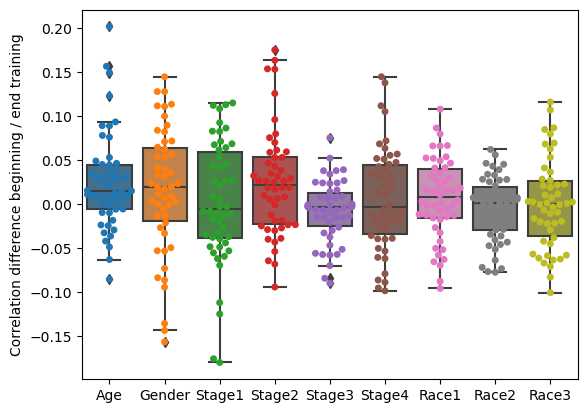

In [12]:
''' 
Plot difference in correlation for each latent feature
'''

delta_corr = (dic_res[firstEpoch].T - dic_res[lastEpoch].T)

fig, ax = plt.subplots()
sns.swarmplot(data=delta_corr)
sns.boxplot(data=delta_corr, saturation=0.5)
ax.set_ylabel("Correlation difference beginning / end training")

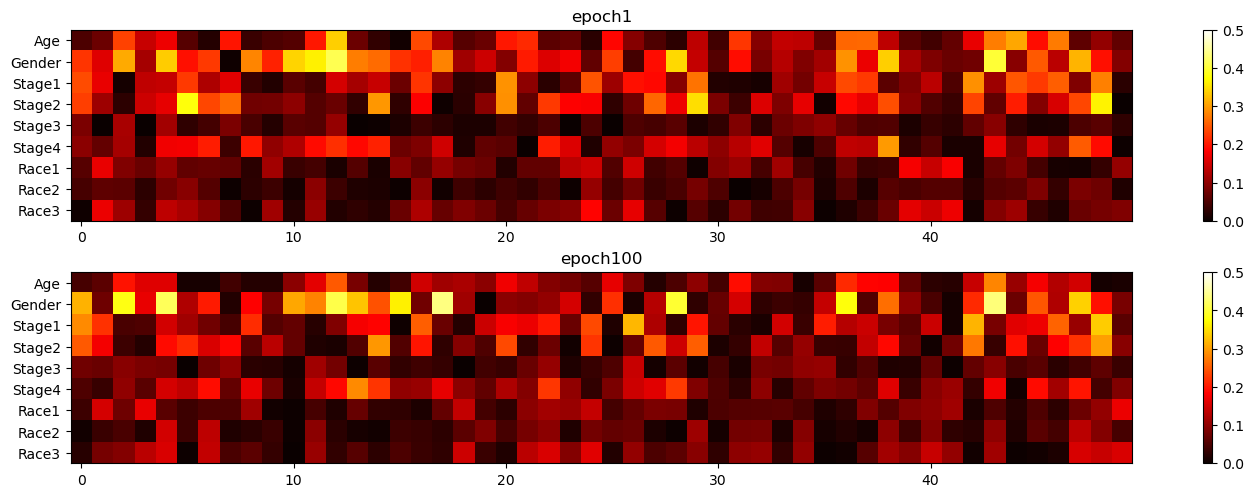

In [13]:
''' Plot heatmap '''

fig, (ax1, ax2) = plt.subplots(2,1,figsize=(15,5))
im = ax1.imshow(dic_res[firstEpoch], cmap='hot', interpolation='nearest', vmin=0, vmax=0.5)
ax1.set_yticks(np.arange(conf.shape[1]), labels=labels_onehot)
ax1.tick_params(axis='both', labelsize=10)
ax1.set_title(firstEpoch)
plt.colorbar(im)
##
im = ax2.imshow(dic_res[lastEpoch], cmap='hot', interpolation='nearest',vmin=0, vmax=0.5)
ax2.set_yticks(np.arange(conf.shape[1]), labels=labels_onehot)
ax2.tick_params(axis='both', labelsize=10)
ax2.set_title(lastEpoch)
plt.colorbar(im)
plt.tight_layout()

In [23]:
''' 
Hypothesis for deconfounding (from observation of gender): 

If latent feature is very deconfounded, adversarial training doesn't deconfounds / even confounds more 
''' 

## Hihgly confounded latent features --> we would expect little change:
print((dic_res[firstEpoch].T[dic_res[firstEpoch].T > 0.3] - dic_res[lastEpoch].T[dic_res[firstEpoch].T > 0.3]).mean())

## Little confounded latent features --> we would expect large change:
print((dic_res[firstEpoch].T[dic_res[firstEpoch].T < 0.3] - dic_res[lastEpoch].T[dic_res[firstEpoch].T < 0.3]).mean())

Age            NaN
Gender   -0.004106
dtype: float64
Age       0.007911
Gender    0.005221
dtype: float64
